In [49]:
import data
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

tickers = assets = ["BTCUSDT", "DOGEUSDT", "ETHUSDT", "SOLUSDT", "XRPUSDT"]
dfs = [
    data.load_asset(asset, sampling="1d") for asset in assets
]
for df in dfs:
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)   
dfs = [
    df[(df.index >= '2022-01-01') & (df.index <= '2025-01-01')] for df in dfs
]

START_DATE = '2024-06-13'

OrderedDict([('BTCUSDT', 0.0), ('DOGEUSDT', 0.0), ('ETHUSDT', 0.0), ('SOLUSDT', 1.0), ('XRPUSDT', 0.0)])


C:\Users\IC2594\AppData\Local\Temp\ipykernel_4784\1702856621.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.028786747233349064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hold_portfolio_weights.loc[current_date] = [*hold_cleaned_weights.values(), portfolio_return]


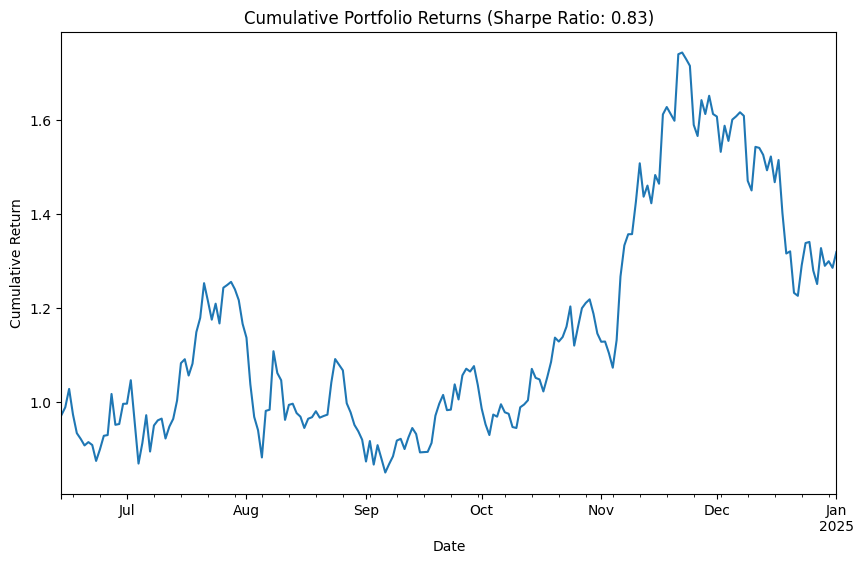

In [50]:
from pypfopt import EfficientFrontier, risk_models, expected_returns

train_dfs = [
    df[(df.index < START_DATE)] for df in dfs
]


returns = [df["Return"] for df in train_dfs]
opens = pd.concat([df["Open"] for df in train_dfs], axis=1)
opens.columns = tickers
mean_returns = expected_returns.mean_historical_return(opens.iloc[-365:], frequency=365)
cov_matrix = risk_models.sample_cov(opens)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe(risk_free_rate=-1)
hold_cleaned_weights = ef.clean_weights()

print(hold_cleaned_weights)


hold_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    hold_portfolio_weights.loc[current_date] = 0
    hold_portfolio_weights.loc[current_date] = [*hold_cleaned_weights.values(), portfolio_return]

portfolio_cumulative_returns = (1 + hold_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(hold_portfolio_weights)) - 1
portfolio_annualized_volatility = hold_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = hold_portfolio_weights['Return'].mean() / hold_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

C:\Users\IC2594\AppData\Local\Temp\ipykernel_4784\1435017945.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.010917884336799966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]
C:\Users\IC2594\AppData\Local\Temp\ipykernel_4784\1435017945.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.98751' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]
C:\Users\IC2594\AppData\Local\Temp\ipykernel_4784\1435017945.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01249' has dtype incompatible

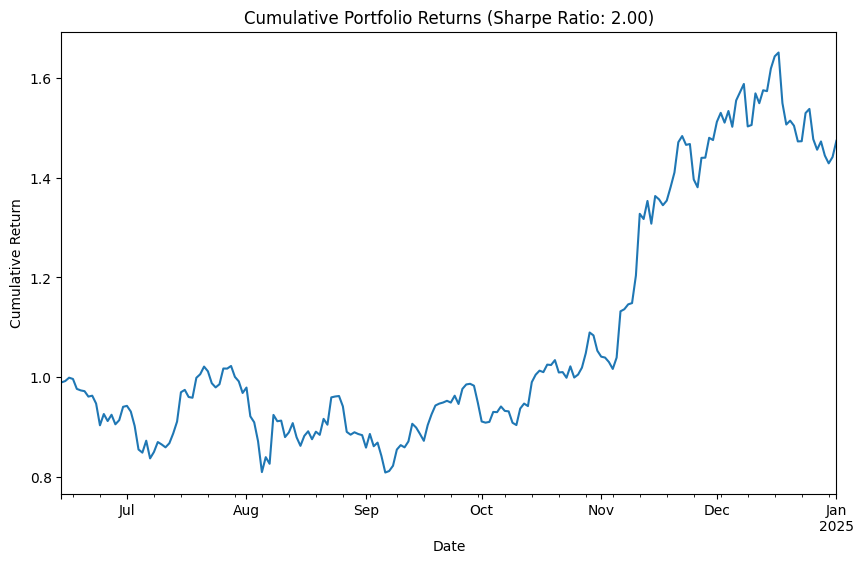

In [52]:
portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])

# Define the start date
start_date = pd.Timestamp(START_DATE)

# Iterate through each day after March 1, 2024
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]

    # Calculate expected returns and covariance matrix using the latest data
    mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
    cov_matrix = risk_models.sample_cov(data_up_to_today)

    # Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mean_returns, cov_matrix)
    weights = ef.max_sharpe(risk_free_rate=-1)
    cleaned_weights = ef.clean_weights()

    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    portfolio_weights.loc[current_date] = 0
    portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = portfolio_weights['Return'].mean() / portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [70]:
predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_Close_predictions.csv').set_index('Date') for tick in tickers
]

Clopred_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])

# Define the start date
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]
    predictions = [
        p_df.loc[str(current_date.date())] for p_df in predictions_dfs
    ]

    # Calculate expected returns and covariance matrix using the latest data
    mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
    cov_matrix = risk_models.sample_cov(data_up_to_today)

    # Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mean_returns, cov_matrix)
    weights = ef.max_sharpe(risk_free_rate=-1)
    cleaned_weights = ef.clean_weights()

    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    Clopred_portfolio_weights.loc[current_date] = 0
    Clopred_portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + Clopred_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = Clopred_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = Clopred_portfolio_weights['Return'].mean() / Clopred_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

C:\Users\IC2594\AppData\Local\Temp\ipykernel_4784\4013303570.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.010917884336799966' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Clopred_portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]


KeyError: '2024-10-26'

In [69]:
str(pd.Timestamp('2024-06-14 00:00:00').date())

'2024-06-14'